In [0]:
import numpy as np
import pandas as pd
import re

# Start of preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#drive.flush_and_unmount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Store in DataFrame

##### Store dataset in pandas dataframe. Only keep rows with narratives.

In [3]:
master_df = pd.read_csv('/content/drive/My Drive/Consumer_Complaints.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
proc_df = master_df.dropna(subset=['Consumer complaint narrative'])

### Count of Company Responses

In [5]:
proc_df['Company response to consumer'].value_counts()

Closed with explanation            359418
Closed with non-monetary relief     54254
Closed with monetary relief         24334
Closed                               3741
Untimely response                    2935
Name: Company response to consumer, dtype: int64

### Sample the Data

#####Take an even sample of 20,000 responses: w/ explanation and w/ monetary relief

In [0]:
tmp_df_1 = proc_df[proc_df['Company response to consumer']=='Closed with explanation'].sample(20000, random_state=42)

tmp_df_2 = proc_df[proc_df['Company response to consumer']=='Closed with monetary relief'].sample(20000, random_state=42)

df = tmp_df_1.append(tmp_df_2)

### Create Dictionary to Replace Target Responses with Binary

In [7]:
replace_dict = {'Closed with explanation': 0, 'Closed with monetary relief': 1}

df['Company response to consumer'].replace(replace_dict, inplace=True)

df['Company response to consumer'].value_counts()

1    20000
0    20000
Name: Company response to consumer, dtype: int64

### Clean Text Data

##### Clean data so that only alphabetic letters remain. Also remove capital Xs because they are used to conceal personal information.

In [0]:
clean = [re.sub('[^A-WY-Za-z]', ' ', nar) for nar in df['Consumer complaint narrative']]

df['Cleaned narratives'] = [nar for nar in clean]

### Lemmatize Text

##### Tokenize and lemmatize the text data

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

split_nars = [nar.split() for nar in df['Cleaned narratives']]

lem_nars = [[lemmatizer.lemmatize(word) for word in nar] for nar in split_nars]

df['Cleaned narratives'] = [' '.join(nar) for nar in lem_nars]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Checkpoint 1: Lemmatized Text

In [0]:
import pickle

data_path = '/content/drive/My Drive/'

file_path = 'pickled_training_data_ibm/'

# Save pickle:
#pickle.dump(df, open(data_path + file_path + 'lemmatized_df_v2.pkl', 'wb'))

# Load pickle:
df = pickle.load(open(data_path + file_path + 'lemmatized_df_v2.pkl', 'rb'))

FileNotFoundError: ignored

## Combine Products and Issues

In [0]:
combined_products, combined_issues = [], []

for ith_tuple in list(zip(list(df['Product']), list(df['Sub-product']))):
  
  comb_string = ' '.join([str(ith_tuple[0]), str(ith_tuple[1])])

  combined_products.append(comb_string)

for jth_tuple in list(zip(list(df['Issue']), list(df['Sub-issue']))):

  comb_string = ' '.join([str(jth_tuple[0]), str(jth_tuple[1])])

  combined_issues.append(comb_string)

In [0]:
df['Combined_products'], df['Combined_issues'] = combined_products, combined_issues

df['Combined_products'] = df['Combined_products'].apply(lambda x: x.lower())

df['Combined_issues'] = df['Combined_issues'].apply(lambda x: x.lower())

### Train Test Split

##### Split data into train, val, and test splits

In [0]:
# Split the data into train and test data

from sklearn.model_selection import train_test_split

X = df[['Combined_products', 'Combined_issues', 'Tags', 'Company', 'State', 'Cleaned narratives']]

X = X.fillna('unk')

y = df['Company response to consumer']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=42)

# Create a validation split as well:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=42)

In [14]:
print(X_train.shape, X_val.shape, X_test.shape)

print(y_train.shape, y_val.shape, y_test.shape)

(25600, 6) (6400, 6) (8000, 6)
(25600,) (6400,) (8000,)


### Vectorize, Reduce, and Scale the Text Features

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

import time

start = time.time()

# TFIDF fit_transform

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=5)

train_text_proc = vectorizer.fit_transform(X_train['Cleaned narratives'])

val_text_proc = vectorizer.transform(X_val['Cleaned narratives'])

test_text_proc = vectorizer.transform(X_test['Cleaned narratives'])

print(train_text_proc.shape)

# SVD fit_transform

n_components = 256

svd = TruncatedSVD(n_components=n_components)

train_text_proc = svd.fit_transform(train_text_proc)

val_text_proc = svd.transform(val_text_proc)

test_text_proc = svd.transform(test_text_proc)

print('SVD explained variance:', np.sum(svd.explained_variance_ratio_))

# MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_text_proc = scaler.fit_transform(train_text_proc)

val_text_proc = scaler.transform(val_text_proc)

test_text_proc = scaler.transform(test_text_proc)

### Concatenate Processed Text Features with Categorical Features

In [0]:
cat_cols = ['Combined_products', 'Combined_issues', 'Tags', 'Company', 'State']

X_train, X_val, X_test = X_train[cat_cols], X_val[cat_cols], X_test[cat_cols]

X_train = np.concatenate((X_train, train_text_proc), axis=1)

X_val = np.concatenate((X_val, val_text_proc), axis=1)

X_test = np.concatenate((X_test, test_text_proc), axis=1)

### Add Feature Names to Text Features for Later Preprocessing

In [0]:
col_names = cat_cols + [f'text_{num}' for num in range(256)]

train_df = pd.DataFrame(X_train, columns=col_names)

val_df = pd.DataFrame(X_val, columns=col_names)

test_df = pd.DataFrame(X_test, columns=col_names)

### Build Preprocessor for Categorical Features

In [20]:
! pip install category_encoders

     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

target_enc_feats = ['Company', 'Combined_products', 'Combined_issues', 'State', 'Tags']

target_enc_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                         ('tar_encoder', TargetEncoder(smoothing=1, handle_unknown='ignore')),
                                         ('sim_imputer', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer(transformers=[('target_enc', target_enc_transformer, target_enc_feats)], remainder='passthrough')

### XGBoost Classifier

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[('preprocessor', preprocessor), ('xgb', XGBClassifier(n_estimators=250, tree_method='gpu_hist'))])

param_grid = {'xgb__learning_rate': np.logspace(-2,0,5),
              'xgb__max_depth': np.arange(1,5)}

grid = GridSearchCV(pipe, param_grid, cv=5).fit(train_df, y_train)

print(f'Best params: {grid.best_params_}')

print(f'Training cv score: {max(grid.cv_results_["mean_test_score"])}')

Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 4}
Training cv score: 0.837890625


## IGNORE ANYTHING BELOW HERE: Plot Transformed Features

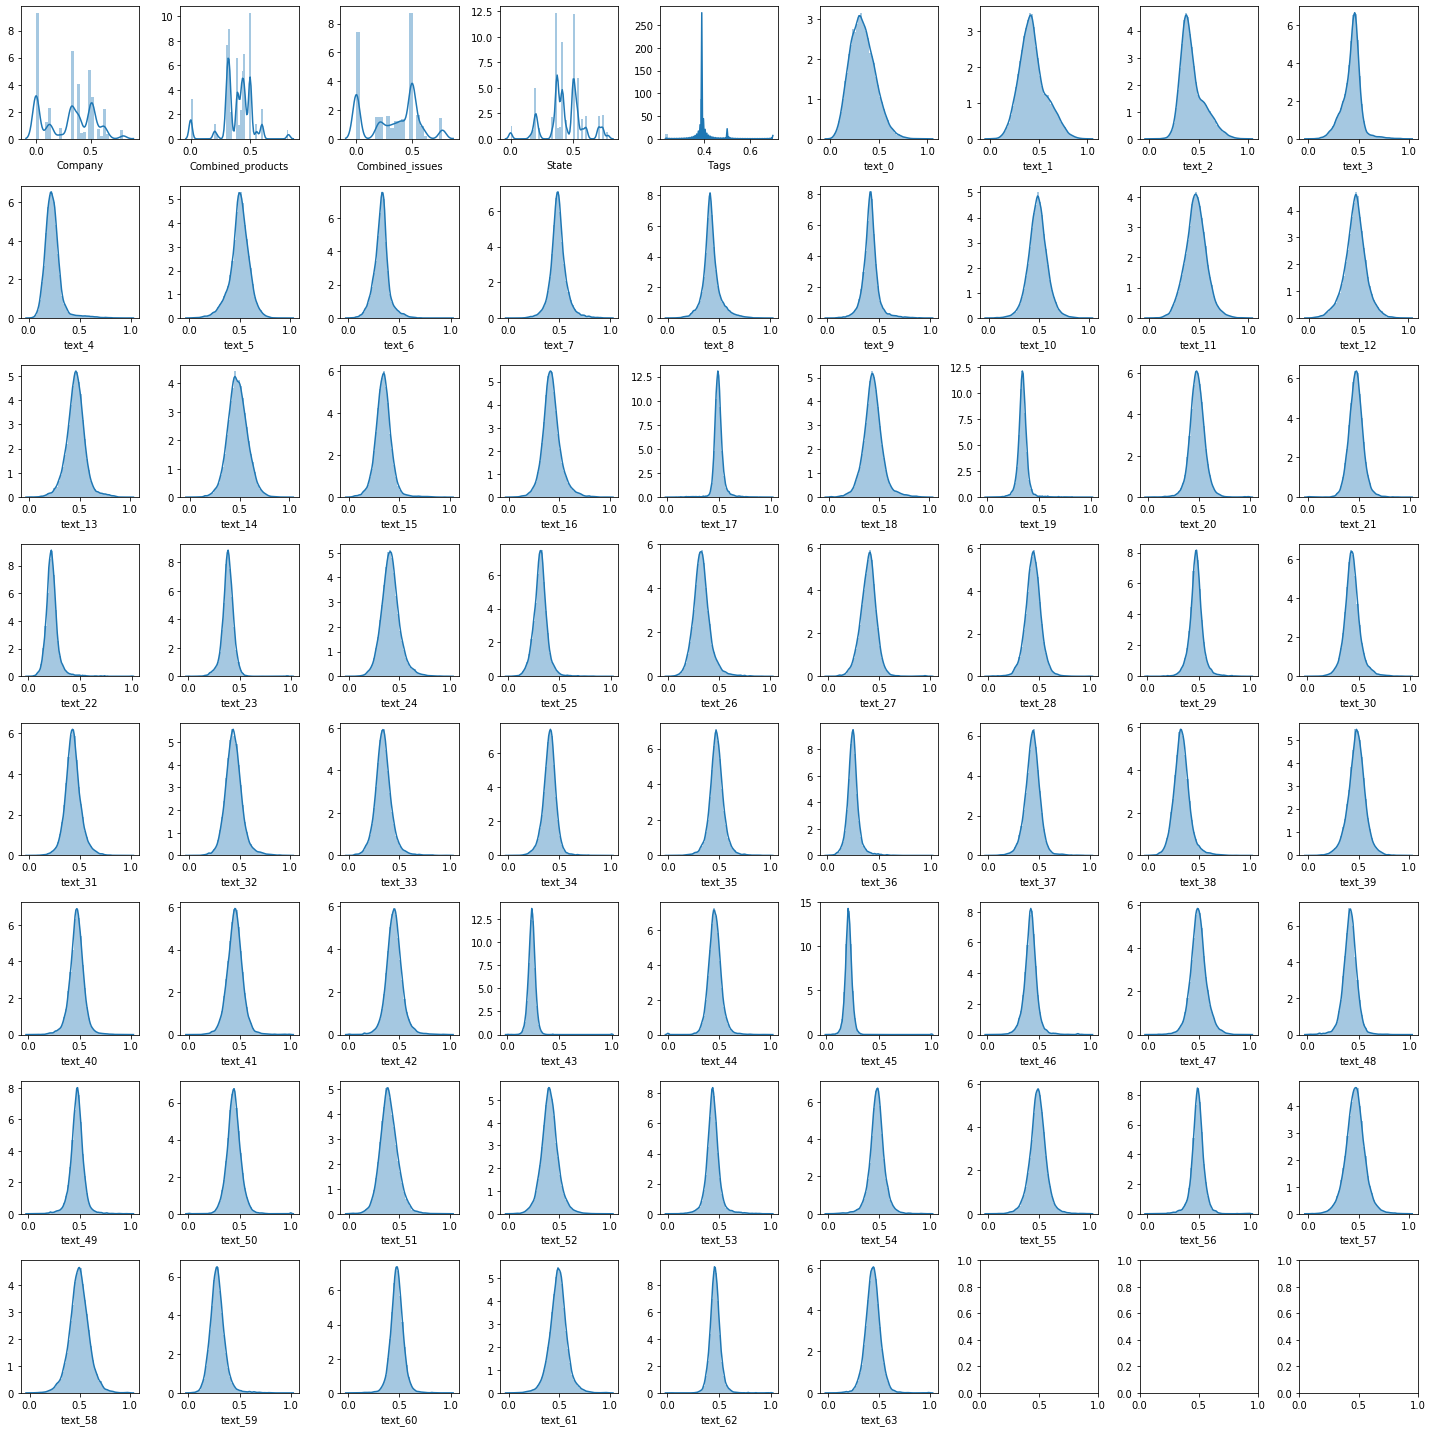

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

examine_df = pd.DataFrame(train_matrix, columns=target_enc_feats + text_counter)

text_counter = [f'text_{num}' for num in range(64)]

fig, ax = plt.subplots(8,9, figsize=(20,20))

x_counter = 0
y_counter = 0

for feat in examine_df.columns:

  if x_counter == 9:
    x_counter = 0
    y_counter += 1

  sns.distplot(examine_df[feat], ax=ax[y_counter, x_counter])

  x_counter += 1

plt.tight_layout()

##### IF SPARSE: MERGE TEXT AND CAT FEATURES

In [0]:
# Combine sparse dataframes:

from scipy.sparse import hstack

train_matrix = hstack([train_cat_proc, train_text_proc])

val_matrix = hstack([val_cat_proc, val_text_proc])

test_matrix = hstack([test_cat_proc, test_text_proc])

In [0]:
'''SAVING THE MATRICIES'''

import pickle

drive_path = '/content/drive/My Drive/'

file_path = 'pickled_training_data_ibm/'

# pickle.dump((train_matrix, val_matrix, test_matrix), open(drive_path + file_path + 'tfidf_red_newcats_X_matrix.pkl', 'wb'))

# pickle.dump((y_train, y_val, y_test), open(drive_path + file_path + 'tfidf_red_newcats_y_targets.pkl', 'wb'))

pickle.dump((train_matrix, val_matrix, test_matrix), open(drive_path + file_path + '28th_proc_trial.pkl', 'wb'))

pickle.dump((y_train, y_val, y_test), open(drive_path + file_path + '28th_proc_y_vars.pkl', 'wb'))

### LOADING THE TRAIN/VAL/TEST MATRICIES

In [0]:
'''LOADING THE MATRICIES:'''

import pickle

drive_path = '/content/drive/My Drive/'
file_path = 'pickled_training_data_ibm/'
train_name = 'train_matrix.pkl'
val_name = 'val_matrix.pkl'
test_name = 'test_matrix.pkl'

train_matrix = pickle.load(open(drive_path + file_path + train_name, 'rb'))
val_matrix = pickle.load(open(drive_path + file_path + val_name, 'rb'))
test_matrix = pickle.load(open(drive_path + file_path + test_name, 'rb'))

y_train, y_val, y_test = pickle.load(open(drive_path + file_path + 'train_val_test_targets.pkl', 'rb'))

In [0]:
print(train_matrix.shape, val_matrix.shape, test_matrix.shape)

print(y_train.shape, y_val.shape, y_test.shape)

(76800, 2901) (19200, 2901) (24000, 2901)
(76800,) (19200,) (24000,)
